In [1]:
# Install TabNet
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 152 kB/s 


In [2]:
!pip install python-utils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#!unzip gdrive/My\ Drive/optiver-realized-volatility-prediction.zip > /dev/null

!unzip gdrive/My\ Drive/preprocessed.zip > /dev/null

Mounted at /content/gdrive/


In [5]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
#from data.dataset import agg_features
#from utils.metrics import RMSPE,RMSPELoss,rmspe
from metrics_volatility import RMSPE,RMSPELoss,rmspe

import warnings
warnings.filterwarnings("ignore")

In [19]:
import os
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

#train,test=read_train_test()
train=pd.read_csv('/content/preprocessed/train_final.csv')
test=pd.read_csv('/content/preprocessed/test_final.csv')
# Aggregating some features
#train, test = agg_features(train,test,train)

# Split features and target
X = train.drop(["row_id", "target", "time_id"], axis=1)
y = train["target"]
X_test = test.drop(["row_id", "time_id"], axis=1)
# Transform stock id to a numeric value
X["stock_id"] = X["stock_id"].astype(int)
X_test["stock_id"] = X_test["stock_id"].astype(int)


categorical_columns = []
categorical_dims = {}

for col in X.columns:
    if col == "stock_id":
        l_enc = LabelEncoder()
        X[col] = l_enc.fit_transform(X[col].values)
        X_test[col] = l_enc.transform(X_test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

cat_idxs = [i for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

cat_dims = [
    categorical_dims[f]
    for i, f in enumerate(X.columns.tolist())
    if f in categorical_columns]
print("heelooo")
tabnet_params = dict(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=1,
        n_d=16,
        n_a=16,
        n_steps=2,
        gamma=2,
        n_independent=2,
        n_shared=2,
        lambda_sparse=0,
        optimizer_fn=Adam,
        optimizer_params=dict(lr=(2e-2)),
        mask_type="entmax",
        scheduler_params=dict(
            T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False
        ),
        scheduler_fn=CosineAnnealingWarmRestarts,
        seed=42,
        verbose=10,
    )

heelooo


In [37]:
from typing import Any, Dict, Optional

tabnet_params = dict(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=1,
        n_d=16,
        n_a=16,
        n_steps=2,
        gamma=2,
        n_independent=2,
        n_shared=2,
        lambda_sparse=0,
        optimizer_fn=Adam,
        optimizer_params=dict(lr=(2e-2)),
        mask_type="entmax",
        scheduler_params=dict(
            T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False
        ),
        scheduler_fn=CosineAnnealingWarmRestarts,
        seed=42,
        verbose=10,
    )

def train_kfold_tabnet(
    n_fold: int,
    X: pd.DataFrame,
    y: pd.DataFrame,
    X_test: pd.DataFrame,
    params: Optional[Dict[str, Any]] = None,
) -> np.ndarray:

  # define and train the Tabnet model with cross validation
  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  # Create out of folds array
  val_predictions = np.zeros((X.shape[0], 1))
  test_predictions = np.zeros(X_test.shape[0])

  for fold, (trn_ind, val_ind) in enumerate(kf.split(X)):
      print(f"Training fold {fold + 1}")
      X_train, X_val = X.iloc[trn_ind].values, X.iloc[val_ind].values
      y_train, y_val = y.iloc[trn_ind].values.reshape(-1, 1), y.iloc[val_ind].values.reshape(-1, 1)

      model=TabNetRegressor(**tabnet_params)
      model.fit(X_train, 
            y_train,
            eval_set=[(X_val, y_val)],
            max_epochs= 200,
            patience=50,
            batch_size=1024*20,
            virtual_batch_size=128,
            num_workers=4,
            drop_last=False,
            eval_metric=[RMSPE],
            loss_fn=RMSPELoss,)
    
      val_predictions[val_ind] = model.predict(X_val)
      test_predictions += model.predict(X_test.values).flatten() / n_fold

      feat_importances =model.feature_importances_
      indices = np.argsort(feat_importances)
      #max_num_features=20
      plt.figure()
      plt.title("Feature importances")
      plt.barh(range(feat_importances), feat_importances[indices],
       color="r", align="center")
      # If you want to define your own labels,
      # change indices to a list of labels on the following line.
      FEATS=X.columns
      plt.yticks(range(feat_importances), [FEATS[idx] for idx in indices])
      plt.ylim([-1, feat_importances])
      plt.show()

  print(f"OOF score across folds: {rmspe(y, val_predictions.flatten())}")

   
  return test_predictions,val_predictions


Training fold 1
epoch 0  | loss: 224.88057| val_0_rmspe: 69.8819 |  0:00:11s
epoch 10 | loss: 0.47675 | val_0_rmspe: 0.33    |  0:01:49s
epoch 20 | loss: 0.35219 | val_0_rmspe: 0.27485 |  0:03:26s
epoch 30 | loss: 0.31271 | val_0_rmspe: 0.30208 |  0:05:04s
epoch 40 | loss: 0.26636 | val_0_rmspe: 0.23485 |  0:06:43s
epoch 50 | loss: 0.2511  | val_0_rmspe: 0.24668 |  0:08:20s
epoch 60 | loss: 0.24007 | val_0_rmspe: 0.22923 |  0:09:55s
epoch 70 | loss: 0.23643 | val_0_rmspe: 0.22945 |  0:11:32s
epoch 80 | loss: 0.25264 | val_0_rmspe: 0.23661 |  0:13:08s
epoch 90 | loss: 0.2318  | val_0_rmspe: 0.22485 |  0:14:44s
epoch 100| loss: 0.23981 | val_0_rmspe: 0.23641 |  0:16:21s
epoch 110| loss: 0.23149 | val_0_rmspe: 0.22441 |  0:17:57s
epoch 120| loss: 0.22731 | val_0_rmspe: 0.23278 |  0:19:33s
epoch 130| loss: 0.22342 | val_0_rmspe: 0.22356 |  0:21:10s
epoch 140| loss: 0.22228 | val_0_rmspe: 0.22752 |  0:22:46s

Early stopping occurred at epoch 143 with best_epoch = 93 and best_val_0_rmspe = 0

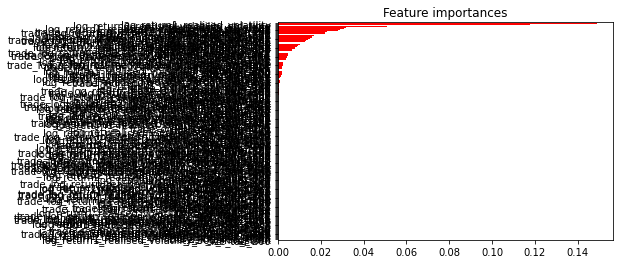

Training fold 2
epoch 0  | loss: 230.41174| val_0_rmspe: 51.10943|  0:00:10s
epoch 10 | loss: 0.38194 | val_0_rmspe: 0.31419 |  0:01:45s
epoch 20 | loss: 0.28868 | val_0_rmspe: 0.26819 |  0:03:20s
epoch 30 | loss: 0.6097  | val_0_rmspe: 0.34658 |  0:04:56s
epoch 40 | loss: 0.28432 | val_0_rmspe: 0.24993 |  0:06:32s
epoch 50 | loss: 0.26538 | val_0_rmspe: 0.2438  |  0:08:08s
epoch 60 | loss: 0.26474 | val_0_rmspe: 0.28012 |  0:09:43s
epoch 70 | loss: 0.26944 | val_0_rmspe: 0.24773 |  0:11:19s
epoch 80 | loss: 0.25012 | val_0_rmspe: 0.24131 |  0:12:54s
epoch 90 | loss: 0.24862 | val_0_rmspe: 0.23955 |  0:14:31s
epoch 100| loss: 0.23746 | val_0_rmspe: 0.23069 |  0:16:07s
epoch 110| loss: 0.23455 | val_0_rmspe: 0.22945 |  0:17:42s
epoch 120| loss: 0.23103 | val_0_rmspe: 0.22453 |  0:19:18s
epoch 130| loss: 0.22749 | val_0_rmspe: 0.22212 |  0:20:53s
epoch 140| loss: 0.22654 | val_0_rmspe: 0.22671 |  0:22:30s
epoch 150| loss: 0.22475 | val_0_rmspe: 0.22359 |  0:24:05s
epoch 160| loss: 0.2225

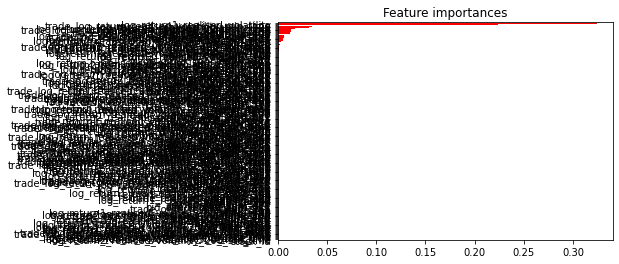

Training fold 3
epoch 0  | loss: 228.89632| val_0_rmspe: 46.2622 |  0:00:09s
epoch 10 | loss: 0.37901 | val_0_rmspe: 0.35095 |  0:01:48s
epoch 20 | loss: 0.27476 | val_0_rmspe: 0.25605 |  0:03:26s
epoch 30 | loss: 0.35924 | val_0_rmspe: 0.30704 |  0:05:04s
epoch 40 | loss: 0.26364 | val_0_rmspe: 0.23749 |  0:06:40s
epoch 50 | loss: 0.26533 | val_0_rmspe: 0.24397 |  0:08:17s
epoch 60 | loss: 0.252   | val_0_rmspe: 0.23877 |  0:09:56s
epoch 70 | loss: 0.2441  | val_0_rmspe: 0.23279 |  0:11:33s
epoch 80 | loss: 0.23561 | val_0_rmspe: 0.22973 |  0:13:10s
epoch 90 | loss: 0.24319 | val_0_rmspe: 0.22992 |  0:14:47s
epoch 100| loss: 0.23244 | val_0_rmspe: 0.22612 |  0:16:25s
epoch 110| loss: 0.22916 | val_0_rmspe: 0.22383 |  0:18:03s
epoch 120| loss: 0.2271  | val_0_rmspe: 0.22282 |  0:19:41s
epoch 130| loss: 0.22405 | val_0_rmspe: 0.21929 |  0:21:20s
epoch 140| loss: 0.22631 | val_0_rmspe: 0.26922 |  0:22:57s
epoch 150| loss: 0.22097 | val_0_rmspe: 0.21653 |  0:24:34s
epoch 160| loss: 0.2192

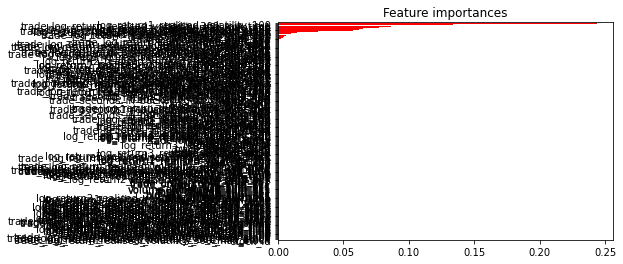

Training fold 4
epoch 0  | loss: 249.48785| val_0_rmspe: 153.27208|  0:00:09s
epoch 10 | loss: 0.63337 | val_0_rmspe: 0.58407 |  0:01:58s
epoch 20 | loss: 0.31119 | val_0_rmspe: 0.27138 |  0:03:38s
epoch 30 | loss: 0.43933 | val_0_rmspe: 0.38345 |  0:05:17s
epoch 40 | loss: 0.26742 | val_0_rmspe: 0.24641 |  0:06:57s
epoch 50 | loss: 0.26931 | val_0_rmspe: 0.24704 |  0:08:37s
epoch 60 | loss: 0.2456  | val_0_rmspe: 0.23031 |  0:10:15s
epoch 70 | loss: 0.23746 | val_0_rmspe: 0.24165 |  0:11:55s
epoch 80 | loss: 0.23099 | val_0_rmspe: 0.22354 |  0:13:33s
epoch 90 | loss: 0.22718 | val_0_rmspe: 0.22058 |  0:15:13s
epoch 100| loss: 0.22632 | val_0_rmspe: 0.21924 |  0:16:53s
epoch 110| loss: 0.22765 | val_0_rmspe: 0.22068 |  0:18:31s
epoch 120| loss: 0.22503 | val_0_rmspe: 0.22022 |  0:20:10s
epoch 130| loss: 0.22027 | val_0_rmspe: 0.34339 |  0:21:48s
epoch 140| loss: 0.21831 | val_0_rmspe: 0.21796 |  0:23:24s
epoch 150| loss: 0.21746 | val_0_rmspe: 0.21458 |  0:25:03s
epoch 160| loss: 0.216

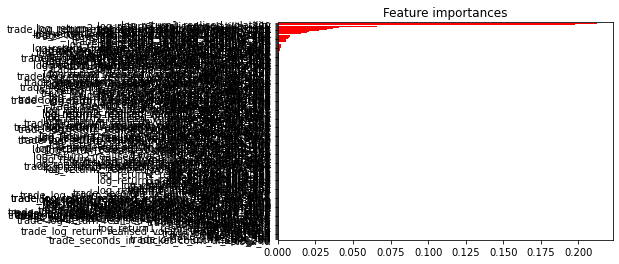

Training fold 5
epoch 0  | loss: 230.47839| val_0_rmspe: 70.5627 |  0:00:09s
epoch 10 | loss: 0.3132  | val_0_rmspe: 0.32068 |  0:01:52s
epoch 20 | loss: 0.27176 | val_0_rmspe: 0.28117 |  0:03:32s
epoch 30 | loss: 0.31952 | val_0_rmspe: 0.2961  |  0:05:14s
epoch 40 | loss: 0.2709  | val_0_rmspe: 0.2561  |  0:06:55s
epoch 50 | loss: 0.28249 | val_0_rmspe: 0.34471 |  0:08:35s
epoch 60 | loss: 0.24516 | val_0_rmspe: 0.24195 |  0:10:32s
epoch 70 | loss: 0.23873 | val_0_rmspe: 0.23145 |  0:12:16s
epoch 80 | loss: 0.23529 | val_0_rmspe: 0.2312  |  0:13:59s
epoch 90 | loss: 0.22867 | val_0_rmspe: 0.22582 |  0:15:40s
epoch 100| loss: 0.22685 | val_0_rmspe: 0.2249  |  0:17:20s
epoch 110| loss: 0.2323  | val_0_rmspe: 0.23588 |  0:19:05s
epoch 120| loss: 0.22339 | val_0_rmspe: 0.2223  |  0:20:45s
epoch 130| loss: 0.21922 | val_0_rmspe: 0.22396 |  0:22:27s
epoch 140| loss: 0.21878 | val_0_rmspe: 0.22251 |  0:24:17s
epoch 150| loss: 0.21675 | val_0_rmspe: 0.22346 |  0:25:58s
epoch 160| loss: 0.2154

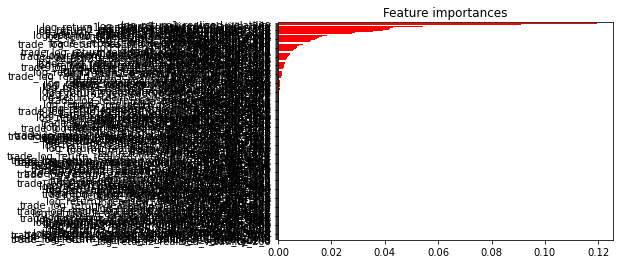

OOF score across folds: 0.21824319287930563


In [38]:
tabnet_preds,val_predictions = train_kfold_tabnet(5, X, y, X_test, tabnet_params)

In [58]:
from sklearn.metrics import r2_score 
print(" TabNet r2_score",r2_score(test["target"], tabnet_preds))
rmspe_score = rmspe(test['target'], tabnet_preds)
print(f'RMSPE for Tabnet model is {rmspe_score}')

TabNet r2_score 0.2315
RMSPE for Tabnet model is 0.853


In [47]:
preds_df=pd.DataFrame(tabnet_preds)
preds_df.to_csv('submission_Tabnet.csv',index = False)

In [55]:
tabnet_ens_preds = [x*3 for x in tabnet_preds]
